# Objectivo
Analisar o conjunto de dados históricos de vendas para extrair insights valiosos que possam ajudar nas decisões estratégicas do negócio.

# Requisitos Técnicos
* Uso de Python (pandas, numpy, matplotlib, seaborn)
* Uso de SQL (pode ser por meio do SQLite ou pandas)
* Criação de visualizações e dashboards interativos (pode usar plotly, matplotlib, seaborn)
* Aplicação de boas práticas de código

# Necessário
* Fazer o download do dataset do Kaggle
* Desenvolver o código necessário para responder às questões
* Criar um **repositório no GitHub** e fazer o upload do notebook desenvolvido
* Documentar adequadamente o código
* O notebook deve conter todas as análises, visualizações e conclusões solicitadas

# Entrega
1. Enviar o link do repositório GitHub através do
forms https://forms.office.com/r/wFtuiTtfij, contendo:
  * o notebook Jupyter/Google Colab com todo o código desenvolvido
  * um **README.md** explicando como executar o projeto e os principais resultados encontrados
  * qualquer arquivo adicional que julgar necessário
  
#### ***2. Prazo de entrega: Até dia 19/05***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute            import KNNImputer
from sklearn.preprocessing     import MinMaxScaler, StandardScaler
import unicodedata
import os
from pathlib import Path

# Fazer upload dos ficheiros manualmente (vai abrir uma janela para selecionar os ficheiros)
# uploaded = files.upload()
NOTEBOOK_PATH = Path().resolve()
PROJECT_ROOT  = NOTEBOOK_PATH.parent
DATA_DIR      = PROJECT_ROOT / "data"

FILES = [
    DATA_DIR / "olist_customers_dataset.csv",
    DATA_DIR / "olist_geolocation_dataset.csv",
    DATA_DIR / "olist_order_items_dataset.csv",
    DATA_DIR / "olist_order_payments_dataset.csv",
    DATA_DIR / "olist_order_reviews_dataset.csv",
    DATA_DIR / "olist_orders_dataset.csv",
    DATA_DIR / "olist_products_dataset.csv",
    DATA_DIR / "olist_sellers_dataset.csv",
    DATA_DIR / "product_category_name_translation.csv",
]

# Importar os ficheiros carregados
# datasets = {}
# for filename in uploaded.keys():
#    df = pd.read_csv(filename,
#                     keep_default_na=True, # Considera valores vazios ('') como NaN
#                     na_values=['', ' '], # Também considera espaços vazios como NaN
#                     dtype=str,  # Força a leitura de todas as colunas como texto (string)
#                     on_bad_lines='skip')  # Ignora linhas mal formatadas (com colunas a mais ou a menos)
#    datasets[filename.replace('.csv', '')] = df

# Confirma quais os Ficheiros Carregados
#print("Ficheiros carregados:", list(datasets.keys()))

# Carrega todos os datasets num dicionário
datasets = {}
for file_path in FILES:
    if not file_path.exists():
        raise FileNotFoundError(f"Falta o ficheiro: {file_path}")
    df = pd.read_csv(
        file_path,
        dtype=str,
        keep_default_na=True,
        na_values=["", " "],
    )
    key = file_path.stem
    datasets[key] = df

print("Datasets carregados:", list(datasets.keys()))

Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_geolocation_dataset.csv to olist_geolocation_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving olist_sellers_dataset.csv to olist_sellers_dataset.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv
Ficheiros carregados: ['olist_customers_dataset', 'olist_geolocation_dataset', 'olist_order_items_dataset', 'olist_order_payments_dataset', 'olist_order_reviews_dataset', 'olist_orders_dataset', 'olist_products_dataset', 'olist_sellers_dataset', 'product_category_name_translation']


# Limpeza dos dados

# Passos de Preparação dos Dados

A preparação e limpeza dos dados baseou-se em manter a consistência e qualidade de cada coluna em todos os datasets e manter a reprodutibilidade e clareza de cada transformação.

# Leitura e Validação Inicial
Primeiro comecei por efetuar o carregamento dos nove ficheiros CSV do conjunto de dados, assegurando que os valores vazios ou mal formatados eram reconhecidos como *NaN*.

# Limpeza e Uniformização dos dados
* **Mapeamento de colunas especiais**: conversão dos dados especiais para númericos e/ou datetime
* **Identficação de business_cols**: métricas financeirasque não devem sofrer imputação automática nem normalização, pos o valor real é essencial para relatórios de faturação e modelagem de receitas.
* **Texto**: todas as colunas textuais foram normalizadas através da remoção de acentuação, conversão para minúsculas, supressão de espaços extras, garantindo consistência nos joins entre tabelas.
* **Duplicados**: eliminação de linhas duplicadas 100% idênticas, evitando inflacionar análises e modelos.
* **Linhas com faltas excessivas**: remoção de registos com mais de metade das colunas em NaN, mantendo apenas observações com informação suficiente.
* **Zip codes**: formatação para strings de 5 dígitos, preservando zeros à esquerda.
* **Números**: transformação de colunas numéricas em tipo float64, seguida de imputação.
* **Imputação de Valores em Falta**
* Nas colunas numéricas, utilizou-se o KNNImputer para estimar valores em falta com base nos vizinhos mais próximos no espaço das variáveis contínuas.
* Nas colunas categóricas, os NaN foram substituídos por "unknown", evitando introduzir categorias fantasma ou erros em agregações.
* Escalonamento das Variáveis
* Aplicação do MinMaxScaler as colunas numéricas, normalizando-as para o intervalo [0,1] e garantindo que variáveis com escalas muito diferentes não enviesassem análises ou modelação.

# Construção do Modelo Relacional

Definição de tabelas, com as chaves primárias (PK) e estrangeiras (FK) conforme o diagrama UML.

População das tabelas a partir dos DataFrames limpos, assegurando a integridade referencial entre:
* customers ↔ orders ↔ order_items ↔ products
* orders ↔ payments
* orders ↔ reviews
* products ↔ category_translation
* customers/sellers ↔ geolocation (via zip_code_prefix).

Este fluxo de preparação garante que os dados estão consistentes, completos e otimizados para análise exploratória e desenvolvimento de modelos preditivos.

In [2]:
import pandas as pd
import numpy as np
import unicodedata
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Mapeamento de colunas especiais por dataset - converte os dados para datetime
date_cols = {
    'olist_orders_dataset': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ],
    'olist_order_reviews_dataset': [
        'review_creation_date',
        'review_reply_timestamp'
    ]
}

# Mapeamento de colunas especiais por dataset - converte as strings para números (float/int), mantendo só como strings aquelas que queremos tratar como identificadores como o CEP
numeric_cols = {
    'olist_customers_dataset': ['customer_zip_code_prefix'],
    'olist_geolocation_dataset': ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
    'olist_order_items_dataset': ['price', 'freight_value'],
    'olist_order_payments_dataset': ['payment_sequential', 'payment_installments', 'payment_value'],
    'olist_order_reviews_dataset': ['review_score'],
    'olist_products_dataset': ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'],
    'olist_sellers_dataset': ['seller_zip_code_prefix']
}

# Colunas de negócio (não imputa, não escala)
business_cols = ['price', 'freight_value']

# Função de limpeza de texto
def clean_text(s: pd.Series) -> pd.Series:
    def norm(x):
        if pd.isna(x): return x
        txt = unicodedata.normalize('NFKD', str(x))
        txt = ''.join(c for c in txt if not unicodedata.combining(c))
        return txt.strip().lower()
    return s.map(norm)

# Loop de limpeza dos dados
for name, df in datasets.items():
    # Limpeza de texto (clean_text)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = clean_text(df[col])

    # Transformação de colunas de texto em objectos datetime
    if name in date_cols:
        for col in date_cols[name]:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')

    # Conversão de numéricos - os zip_codes são mantidos como strings de 5 digitos (zfill) para presevar zerosà esuqerda essenciais para joins com geolocation
    # as restantes colunas são transformados em float/int de forma a garantir que as operações matemáticas e estatísticas (somas, médias) funcionem corretamente
    if name in numeric_cols:
        for col in numeric_cols[name]:
            if col in df.columns:
                # ex.: zip_codes mantidos como string de 5 dígitos
                if 'zip_code_prefix' in col:
                    df[col] = df[col].astype(str).str.zfill(5)
                else:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remoção de duplicados - eliminar linhas repetidas que podem surgir em joins ou importações múltiplas, evitando assim o enviesamento de contagens, somas e análises
    df = df.drop_duplicates()

    # Eliminar linhas onde faltam mais de 50% dos dados - descartar registros com informações muito incompletas, isto porque estas linhas dificilmente irão oferecer um valor analítico e podem confundir imputação e modelagem
    threshold = int(len(df.columns) * 0.5)
    df = df.dropna(thresh=threshold, axis=0)

    # Descartar registros onde faltem price ou freight_value
    if name == 'olist_order_items_dataset':
        df = df.dropna(subset=business_cols)

    # Imputação de valores em falta só para colunas numéricas que não sejam de negócio
    #    - colunas numéricas: KNNImputer
    num_feats = [c for c in df.columns if df[c].dtype in ['float64','int64'] and c not in business_cols]
    if num_feats:
      # KNNImputer preenche valores númericos com base em "vizinhos" semelhantes, preservando a estrutura multivariada - evita descartar colunas inteiras ou registros úteis, manendo assim o máximo de dados possíveis para análises de machine learning
        imputer = KNNImputer(n_neighbors=5)
        df[num_feats] = imputer.fit_transform(df[num_feats])
    #    - colunas categóricas: preencher NaN com 'unknown' - isto é tratar categorias ausentes como "unknow", para não perder linhas e ainda capturar "missingness" como possível sinal
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna('unknown')

    # Normalização / escalonamento
    #    - normalização das colunas numéricas (excepto as de negócio, como price e freight_value) para o intervalo [0,1], este passo é importante
    # porque permite usar algoritmos de distância (KNN, clustering) ou redes neurais
    if num_feats:
        scaler = MinMaxScaler()
        df[num_feats] = scaler.fit_transform(df[num_feats])

    datasets[name] = df
    print(f"{name}: {len(df)} linhas limpas, {len(num_feats)} colunas numéricas escalonadas")
    print("\n")

print("Limpeza e normalização concluídas para todos os datasets")
print("\n")

olist_customers_dataset: 99441 linhas limpas, 0 colunas numéricas escalonadas


olist_geolocation_dataset: 720495 linhas limpas, 2 colunas numéricas escalonadas


olist_order_items_dataset: 112650 linhas limpas, 0 colunas numéricas escalonadas


olist_order_payments_dataset: 103886 linhas limpas, 3 colunas numéricas escalonadas


olist_order_reviews_dataset: 99224 linhas limpas, 1 colunas numéricas escalonadas


olist_orders_dataset: 99441 linhas limpas, 0 colunas numéricas escalonadas


olist_products_dataset: 32950 linhas limpas, 4 colunas numéricas escalonadas


olist_sellers_dataset: 3095 linhas limpas, 0 colunas numéricas escalonadas


product_category_name_translation: 71 linhas limpas, 0 colunas numéricas escalonadas


Limpeza e normalização concluídas para todos os datasets




# Análise Exploratória de Dados

**a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?**



Tabela do volume de pedidos por mês


ano_mes  total_pedidos
2016-09              4
2016-10            324
2016-12              1
2017-01            800
2017-02           1780
2017-03           2682
2017-04           2404
2017-05           3700
2017-06           3245
2017-07           4026
2017-08           4331
2017-09           4285
2017-10           4631
2017-11           7544
2017-12           5673
2018-01           7269
2018-02           6728
2018-03           7211
2018-04           6939
2018-05           6873
2018-06           6167
2018-07           6292
2018-08           6512
2018-09             16
2018-10              4




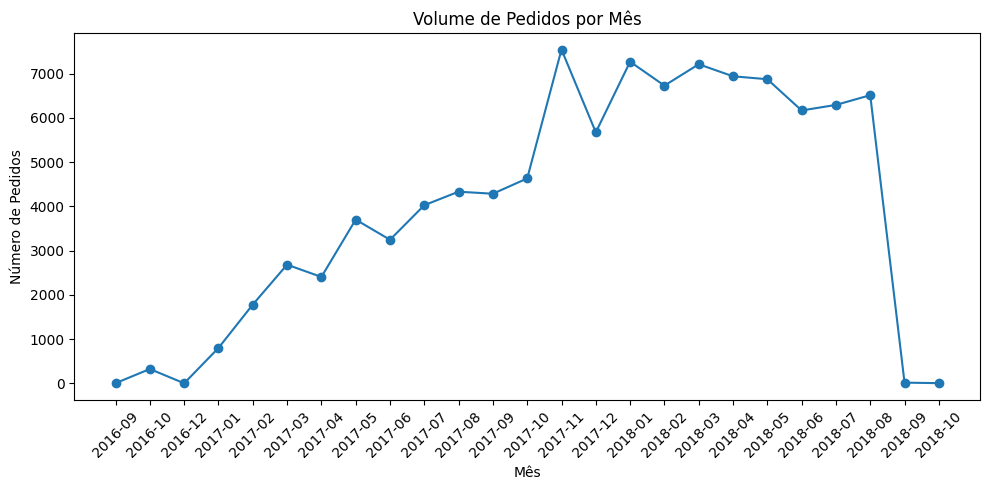

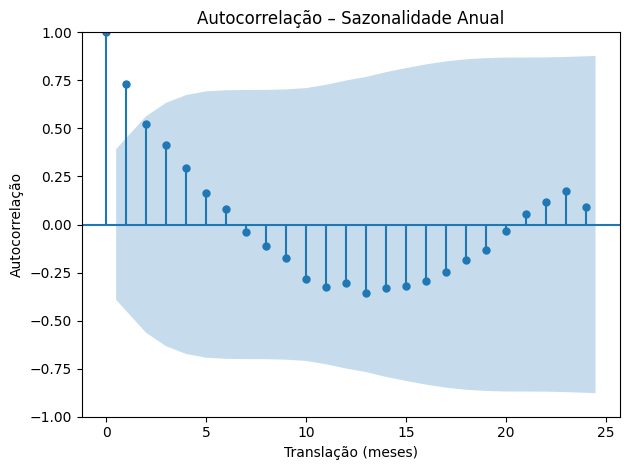

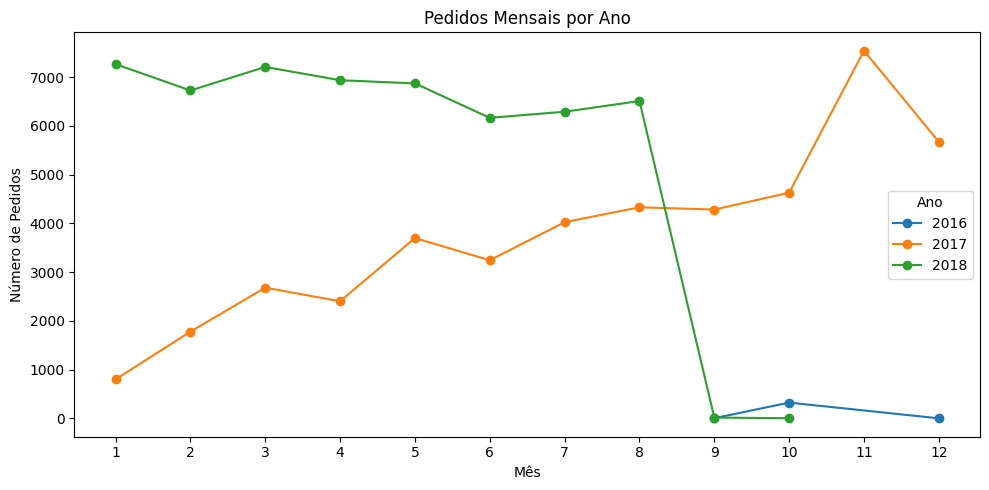

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Extrair o DataFrame de encomendas
orders = datasets['olist_orders_dataset']
print("\n")

# Converter e criar chave ano_mes
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp'], errors='coerce'
)
orders['ano_mes'] = orders['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Agrupar e contar o volume mensal gerando o DataFrame com as colunas ano_mes e total_pedidos
volume_mensal_df = (
    orders
    .groupby('ano_mes')
    .size()
    .reset_index(name='total_pedidos')
    .sort_values('ano_mes')
)

# Exibir a tabela completa
print("Tabela do volume de pedidos por mês")
print("\n")
print(volume_mensal_df.to_string(index=False))
print("\n")

# Plot histórico - gera o gráfico de linhas com marcadores, evidenciando picos e vales ao longo do tempo
plt.figure(figsize=(10,5))
plt.plot(volume_mensal_df['ano_mes'], volume_mensal_df['total_pedidos'], marker='o')
plt.xticks(rotation=45)
plt.title('Volume de Pedidos por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Pedidos')
plt.tight_layout()
plt.show()
print("\n")

#Converte a coluna ano_mes em índice datetime e plota a autocorrelação para detectar repetições padrão a cada 12 meses
monthly_series = volume_mensal_df.set_index(
    pd.to_datetime(volume_mensal_df['ano_mes'] + '-01')
)['total_pedidos']
monthly_series = monthly_series.dropna()

# ACF (autocorrelação) para verificar sazonalidade
n_obs = len(monthly_series)
plot_acf(monthly_series, lags=n_obs-1)
plt.title('Autocorrelação – Sazonalidade Anual')
plt.xlabel('Translação (meses)')
plt.ylabel('Autocorrelação')
plt.tight_layout()
plt.show()
print("\n")

# Overlay por ano - reorganiza os dados para traçar cada ano numa cor diferente
df_ov = volume_mensal_df.copy()
df_ov['data'] = pd.to_datetime(df_ov['ano_mes'] + '-01')
df_ov['year'] = df_ov['data'].dt.year
df_ov['month'] = df_ov['data'].dt.month

plt.figure(figsize=(10,5))
for yr, grp in df_ov.groupby('year'):
    plt.plot(grp['month'], grp['total_pedidos'], marker='o', label=str(yr))
plt.title('Pedidos Mensais por Ano')
plt.xlabel('Mês')
plt.ylabel('Número de Pedidos')
plt.xticks(range(1,13))
plt.legend(title='Ano')
plt.tight_layout()
plt.show()
print("\n")


**Resposta:**
Observando a tabela do volume de pedidos por mês temos um forte crescimento de pedidos entre o início de 2017 e meados de 2018.
Relativamente à sanozalidade, observa-se picos anuais em novembro/dezembro e janeiro. Estes picos podem dever-se à época festiva destes meses e seguintes promoções de ano novo.
Assim sendo, observa-se uma sazonalidade no inicio e no fim de cada ano, o que pode refletir o comportamento típico de compras de Natal, seguido de promoções no início de cada ano.

**b) Qual a distribuição do tempo de entrega dos pedidos?**

Estatísticas do tempo de entrega (dias):
count    96476
mean        12
std          9
min          0
25%          6
50%         10
75%         15
max        209
Name: delivery_time_days, dtype: int64



Percentis do tempo de entrega:
0.25     6
0.50    10
0.75    15
0.90    23
0.99    46
Name: delivery_time_days, dtype: int64




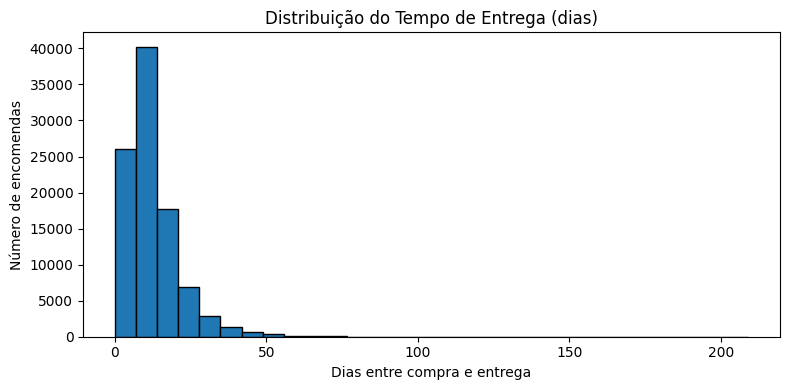

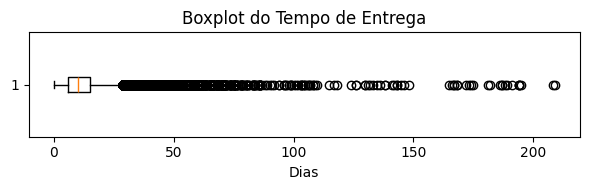

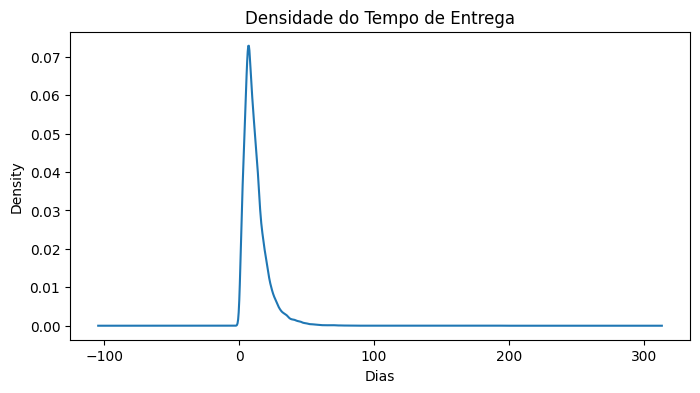

delivery_time_days
(0, 7]       33685
(7, 14]      36398
(14, 30]     22262
(30, 60]      3830
(60, 365]      288
dtype: int64




In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Extrair o DataFrame de encomendas e garantir que as colunas de data são datetime
orders = datasets['olist_orders_dataset']
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp'], errors='coerce'
)
orders['order_delivered_customer_date'] = pd.to_datetime(
    orders['order_delivered_customer_date'], errors='coerce'
)

# Calcular o tempo de entrega em dias (data de entrega – data de compra)
orders['delivery_time_days'] = (
    orders['order_delivered_customer_date']
    - orders['order_purchase_timestamp']
).dt.days

# Remover valores negativos ou absurdos (se existirem)
orders = orders[orders['delivery_time_days'] >= 0]

# Estatísticas descritivas
stats = orders['delivery_time_days'].describe().astype(int)
print("Estatísticas do tempo de entrega (dias):")
print(stats)
print("\n")

# Percentis de interesse para ver a dispersão além dos quartis
percentis = orders['delivery_time_days'].quantile([0.25, 0.5, 0.75, 0.90, 0.99])
print("\nPercentis do tempo de entrega:")
print(percentis.astype(int))
print("\n")

# Histograma para visualizar a forma da distribuição
plt.figure(figsize=(8,4))
plt.hist(
    orders['delivery_time_days'].dropna(), # elimina NaNs
    bins=30, # número de barras
    edgecolor='k' # borda preta para melhor leitura
)
plt.title('Distribuição do Tempo de Entrega (dias)')
plt.xlabel('Dias entre compra e entrega')
plt.ylabel('Número de encomendas')
plt.tight_layout()
plt.show()
print("\n")

# Boxplot para visualizar outliers
plt.figure(figsize=(6,2))
plt.boxplot(orders['delivery_time_days'].dropna(), vert=False)
plt.title('Boxplot do Tempo de Entrega')
plt.xlabel('Dias')
plt.tight_layout()
plt.show()
print("\n")

# Gráfico de densidade de forma a perceber o "pico" com suavização
orders['delivery_time_days'].plot(kind='kde', figsize=(8,4))
plt.title('Densidade do Tempo de Entrega')
plt.xlabel('Dias')
plt.show()

# Tabela de contagens por faixa - agrupa em bins interpretávies (0-7, 8-14, 15-30, >30 dias)
faixas = pd.cut(orders['delivery_time_days'], bins=[0,7,14,30,60,365])
print(orders.groupby(faixas, observed=True).size()) # Só listas as faixas que realmente têm pedidos
print("\n")


**Resposta:**
Analisando os resultados obtidos observa-se que:
* 50% das encomendas são entregues até 12 dias, tempo inidcado na média calculada
* para além disso, pode-se observar que 90% das encomendas são entregues até aos 23 dias.
Analisando os gráficos observa-se um pico acentuado entre os 6-12 dias, refletindo a maior parte das entregas dentro de duas semanas.
O boxplot por sua vez evidencia uma longa cauda de outliers acima de 50-100 dias, mas que apenas representam 1% dos casos.

**c) Qual a relação entre o valor do frete e a distância de entrega?**

Correlação de Pearson entre distância e frete: 0.37



Frete médio por faixa de distância:
           avg_frete  count
dist_bin                  
0–5       16.659790  71881
5–10      21.672190  21363
10–20     27.291627  11701
20–50     36.386001   7147
50–100    26.222500      4








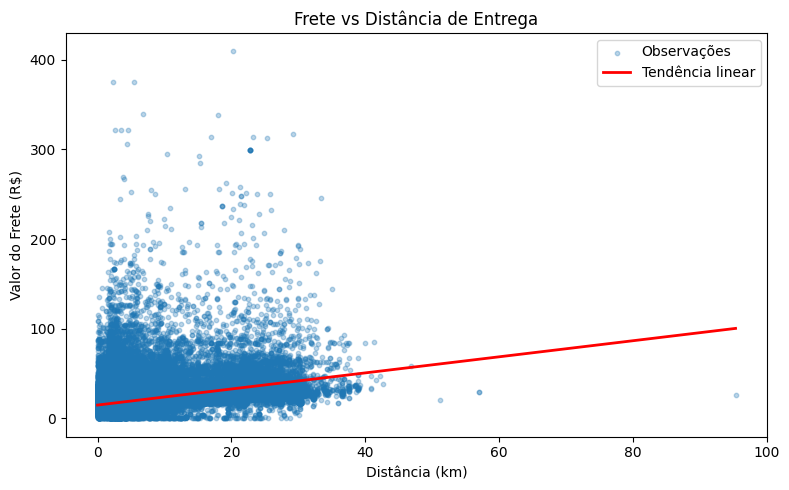

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extrair as tabelas necessárias
orders    = datasets['olist_orders_dataset']
items     = datasets['olist_order_items_dataset']
customers = datasets['olist_customers_dataset']
sellers   = datasets['olist_sellers_dataset']
geoloc    = datasets['olist_geolocation_dataset']

# Garantir tipos corretos e prefixos com 5 dígitos
for df, col in [
    (customers, 'customer_zip_code_prefix'),
    (sellers,   'seller_zip_code_prefix'),
    (geoloc,    'geolocation_zip_code_prefix')
]:
    df[col] = df[col].astype(str).str.zfill(5)

# Converter lat/lng para float e agregar média por prefixo
geoloc['geolocation_lat'] = pd.to_numeric(geoloc['geolocation_lat'], errors='coerce')
geoloc['geolocation_lng'] = pd.to_numeric(geoloc['geolocation_lng'], errors='coerce')
geo = (
    geoloc
    .groupby('geolocation_zip_code_prefix', as_index=False)
    .agg(lat_prefix=('geolocation_lat','mean'),
         lng_prefix=('geolocation_lng','mean'))
)

# Associar coordenadas de prefixo a clientes e vendedores
customers = customers.merge(
    geo,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={'lat_prefix':'cust_lat','lng_prefix':'cust_lng'})

sellers = sellers.merge(
    geo,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={'lat_prefix':'sell_lat','lng_prefix':'sell_lng'})

# 5) Montar DataFrame unificado de itens com frete e coordenadas
df = (
    items
    # manter apenas freight_value e identificadores
    .merge(orders[['order_id','customer_id']], on='order_id', how='left')
    .merge(customers[['customer_id','cust_lat','cust_lng']], on='customer_id', how='left')
    .merge(sellers[['seller_id','sell_lat','sell_lng']], on='seller_id', how='left')
)

# Converter colunas de interesse para numéricos e eliminar linhas com dados ausentes
for c in ['freight_value','cust_lat','cust_lng','sell_lat','sell_lng']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=['freight_value','cust_lat','cust_lng','sell_lat','sell_lng'])

# Função Haversine para calcular distância em km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # raio da Terra em km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi    = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a       = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Aplicar Haversine linha a linha para obter distance_km
df['distance_km'] = haversine(
    df['sell_lat'], df['sell_lng'],
    df['cust_lat'], df['cust_lng']
)

# Estatísticas de correlação
corr = df['distance_km'].corr(df['freight_value'])
print(f"Correlação de Pearson entre distância e frete: {corr:.2f}")
print("\n")

# Estatísticas por binned distance, para ver média de frete
bins = [0, 5, 10, 20, 50, 100, np.inf]
labels = ['0–5','5–10','10–20','20–50','50–100','>100']
df['dist_bin'] = pd.cut(df['distance_km'], bins=bins, labels=labels, right=False)
bin_stats = (
    df
    .groupby('dist_bin', observed=True)
    .agg(
        avg_frete=('freight_value','mean'),
        count=('freight_value','size')
    )
)
print("\nFrete médio por faixa de distância:\n", bin_stats)
print("\n")

# Plot scatter + linha de regressão simples
plt.figure(figsize=(8,5))
plt.scatter(df['distance_km'], df['freight_value'], alpha=0.3, s=10, label='Observações')
print("\n")

# Ajustar e plotar reta de regressão linear
coef = np.polyfit(df['distance_km'], df['freight_value'], 1)
poly1d = np.poly1d(coef)
x_vals = np.linspace(0, df['distance_km'].max(), 100)
plt.plot(x_vals, poly1d(x_vals), color='red', linewidth=2, label='Tendência linear')
print("\n")

plt.title('Frete vs Distância de Entrega')
plt.xlabel('Distância (km)')
plt.ylabel('Valor do Frete (R$)')
plt.legend()
plt.tight_layout()
plt.show()
print("\n")

**Respota:**
Observando os dados obtidos temos um aumento gradual do valor médio do frete conforme a distância cresce, até cerca de 50km.
A correlacção de 0.37 sugere que a distância explica parte da variação do preço do frete. Outros fatores como peso, volume, promoções também podem ter influência no preço final, sendo por isso necessário refinar esta análise incluindo esses fatores.

**d) Quais são as categorias de produtos mais vendidas em termos de faturamento?**

Top 10 categorias por faturamento (produto + frete):

 product_category_name  faturamento_total
          beleza_saude         1441248.07
    relogios_presentes         1305541.61
       cama_mesa_banho         1241681.72
         esporte_lazer         1156656.48
informatica_acessorios         1059272.40
      moveis_decoracao          902511.79
 utilidades_domesticas          778397.77
            cool_stuff          719329.95
            automotivo          685384.32
    ferramentas_jardim          584219.21




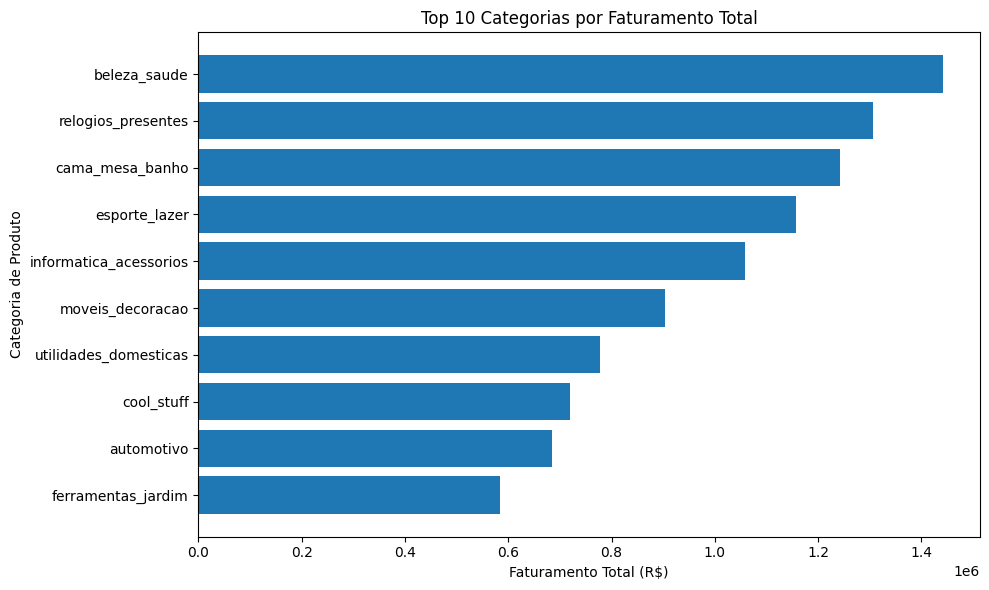

In [6]:
import pandas as pd

# Extrair DataFrames
items    = datasets['olist_order_items_dataset']
products = datasets['olist_products_dataset']

# Converter price e freight_value para float e limpar nulos
items['price']         = pd.to_numeric(items['price'], errors='coerce')
items['freight_value'] = pd.to_numeric(items['freight_value'], errors='coerce')
items = items.dropna(subset=['price'])            # garante só preços válidos
items = items[items['price'] > 0]                 # remove itens com preço zero, se relevante

# Juntar items → products ara obter categoria de cada item
df = items.merge(
    products[['product_id','product_category_name']],
    on='product_id',
    how='left'
)

# Calcular faturamento total por categoria (produto + frete)
faturamento_categoria = (
    df
    .groupby('product_category_name', as_index=False)
    .agg(
        total_produto = ('price',        'sum'),
        total_frete   = ('freight_value','sum')
    )
)

# Somar produto + frete para “faturamento completo”
faturamento_categoria['faturamento_total'] = (
    faturamento_categoria['total_produto']
  + faturamento_categoria['total_frete']
)

# Ordenar e extrair o top 10
top10 = faturamento_categoria.sort_values(
    'faturamento_total', ascending=False
).head(10)

# Mostrar o Top de 10 categorias
print("Top 10 categorias por faturamento (produto + frete):\n")
print(top10[['product_category_name','faturamento_total']].to_string(index=False))
print("\n")

# Visualizar com barplot
plt.figure(figsize=(10,6))
plt.barh(
    top10['product_category_name'],
    top10['faturamento_total']
)
plt.gca().invert_yaxis()
plt.title('Top 10 Categorias por Faturamento Total')
plt.xlabel('Faturamento Total (R$)')
plt.ylabel('Categoria de Produto')
plt.tight_layout()
plt.show()
print("\n")


**Resposta:**
Em termos de faturamento as categorias de produtos mais vendidos é beleza_saude, relogios_presentes e cama_mesa_banho.


**e) Quais estados brasileiros possuem o maior valor médio de pedido?**

Top 10 estados por valor médio de pedido:

customer_state  avg_order_value  num_orders
            pb       216.669323         532
            ap       198.151471          68
            ac       197.320370          81
            al       195.413163         411
            ro       186.804211         247
            pa       184.482278         970
            to       177.855699         279
            pi       176.296308         493
            mt       173.259723         903
            rn       172.271743         482




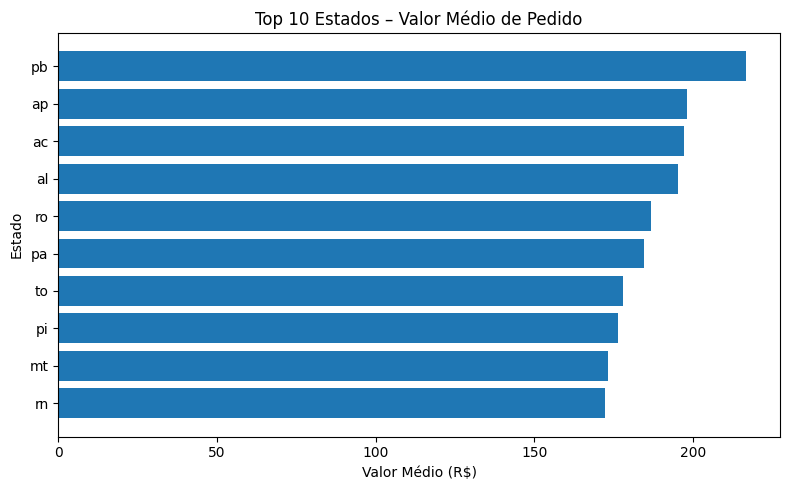

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Extrair DataFrames
orders    = datasets['olist_orders_dataset']
items     = datasets['olist_order_items_dataset']
customers = datasets['olist_customers_dataset']

# Converter price para float e filtrar registros inválidos
items['price'] = pd.to_numeric(items['price'], errors='coerce')
items = items.dropna(subset=['price'])  # remove linhas sem price

# Calcular o valor total de cada encomenda (soma de price)
order_totals = (
    items
    .groupby('order_id', as_index=False)
    .agg(order_value=('price','sum'))
)

# Unir com orders para obter o customer_id de cada pedido
order_totals = order_totals.merge(
    orders[['order_id','customer_id']],
    on='order_id',
    how='left'
)

# Juntar com customers para obter o estado
order_totals = order_totals.merge(
    customers[['customer_id','customer_state']],
    on='customer_id',
    how='left'
)

# Filtrar estados ausentes ou inválidos
order_totals = order_totals[order_totals['customer_state'].notna()]

# Agrupar por estado e calcular estatísticas:
#    - avg_order_value: valor médio do pedido
#    - num_orders:  número de pedidos por estado
state_stats = (
    order_totals
    .groupby('customer_state', as_index=False)
    .agg(
        avg_order_value=('order_value','mean'),
        num_orders=('order_id','count')
    )
    .sort_values('avg_order_value', ascending=False)
)

# Mostrar o Top 10 estados por ticket médio
print("Top 10 estados por valor médio de pedido:\n")
print(state_stats.head(10).to_string(index=False))
print("\n")

# Visualização simples
top10 = state_stats.head(10)
plt.figure(figsize=(8,5))
plt.barh(top10['customer_state'], top10['avg_order_value'])
plt.gca().invert_yaxis()
plt.title('Top 10 Estados – Valor Médio de Pedido')
plt.xlabel('Valor Médio (R$)')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()
print("\n")


**Resposta:**
Os estados que possuem um maior número de pedidos é o Paraíba (PB), seguido do Amapá (AP) e Acre (AC).

# Solução de Problemas de Negócio

**Análise de Retenção:**
Calcule a taxa de clientes recorrentes. Considere um cliente recorrente aquele que fez mais de um pedido no período analisado. Quais insights podemos extrair destes dados?

Total de clientes: 72620
Clientes recorrentes (>1 pedido): 1810
Taxa de recorrência: 2.49%


Distribuição de nº de pedidos por cliente:
num_pedidos
1     70810
2      1688
3        95
4        17
5         5
7         3
9         1
11        1

Taxa de recorrência por estado:
customer_state  taxa_recorrencia  clientes
            ro          0.073446       177
            rr          0.071429        28
            mt          0.058055       689
            rj          0.055246      9521
            sp          0.054643     32264
            df          0.053381      1686
            ba          0.053238      2517
            go          0.053219      1522
            mg          0.051007      8842
            rs          0.047334      4014
            ma          0.046382       539
            es          0.046164      1538
            pr          0.045117      3768
            pi          0.044199       362
            pb          0.043478       391
            ms          0.043165   

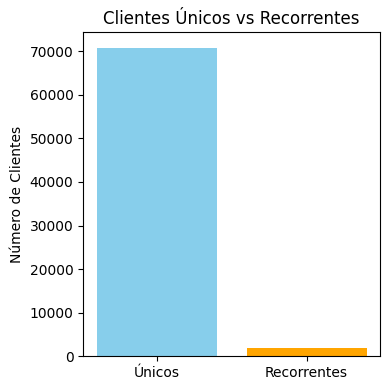

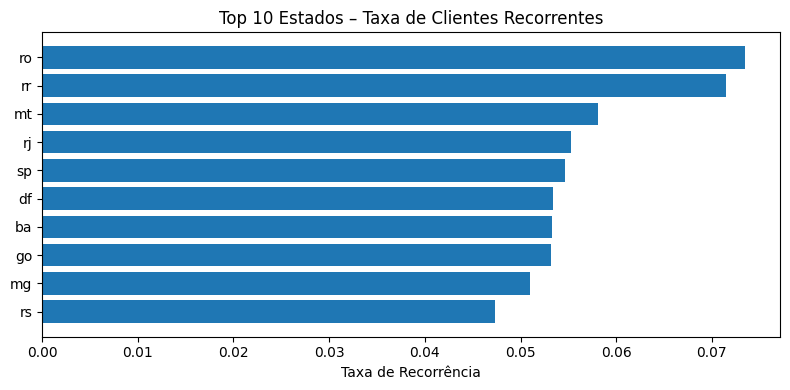

In [8]:
import pandas as pd

# Extrair DataFrames
orders    = datasets['olist_orders_dataset']
customers = datasets['olist_customers_dataset']

# Converter timestamps para datetime
orders['order_purchase_timestamp'] = pd.to_datetime(
    orders['order_purchase_timestamp'], errors='coerce'
)
orders['order_delivered_customer_date'] = pd.to_datetime(
    orders['order_delivered_customer_date'], errors='coerce'
)

# Filtrar apenas pedidos concluídos (“delivered”) de forma a garantir que só são contadas compras concluídas
orders = orders[orders['order_status'] == 'delivered']

# Definir período de análise: últimos 12 meses de forma a evitar o enviesamento e retenção com clientes mais antigos
ultimo = orders['order_purchase_timestamp'].max()
inicio_12m = ultimo - pd.DateOffset(months=12)
orders = orders[orders['order_purchase_timestamp'] >= inicio_12m]

# Juntar orders → customers para trazer o customer_unique_id a cada pedido
df = orders.merge(
    customers[['customer_id','customer_unique_id']],
    on='customer_id',
    how='left'
)
#    - usar o customer_unique_id em vez de customer_id porque o mesmo comprador pode ter múltiplos customer_id em diferentes

# Contar número de pedidos - order_id - por cliente único - customer_unique_id
pedidos_por_cliente = (
    df
    .groupby('customer_unique_id', as_index=False)
    .agg(num_pedidos=('order_id','count'))
)

# Marcar quem é recorrente (>1 pedido)
pedidos_por_cliente['recorrente'] = pedidos_por_cliente['num_pedidos'] > 1

# Calcular total de clientes e quantos são recorrentes
total_clientes   = pedidos_por_cliente['customer_unique_id'].nunique()
recorrentes      = pedidos_por_cliente['recorrente'].sum()
taxa_recorrencia = recorrentes / total_clientes

print(f"Total de clientes: {total_clientes}")
print(f"Clientes recorrentes (>1 pedido): {recorrentes}")
print(f"Taxa de recorrência: {taxa_recorrencia:.2%}")
print("\n")

# Distribuição de pedidos por cliente
dist = pedidos_por_cliente['num_pedidos'].value_counts().sort_index()
print("Distribuição de nº de pedidos por cliente:")
print(dist.to_string())

# Taxa de recorrência por estado (reutilizou-se o df com customer_state)
estado = (
    pedidos_por_cliente
    .merge(customers[['customer_unique_id','customer_state']],
           on='customer_unique_id', how='left')
    .groupby('customer_state', as_index=False)
    .agg(taxa_recorrencia=('recorrente','mean'),
         clientes=('customer_unique_id','count'))
    .sort_values('taxa_recorrencia', ascending=False)
)

print("\nTaxa de recorrência por estado:")
print(estado.to_string(index=False))
print("\n")

# Gráfico da Taxa global
plt.figure(figsize=(4,4))
plt.bar(['Únicos','Recorrentes'], [total_clientes-recorrentes, recorrentes],
        color=['skyblue','orange'])
plt.title('Clientes Únicos vs Recorrentes')
plt.ylabel('Número de Clientes')
plt.tight_layout()
plt.show()
print("\n")

# Gráfico da Taxa por estado (top 10)
top_estados = estado.head(10)
plt.figure(figsize=(8,4))
plt.barh(top_estados['customer_state'], top_estados['taxa_recorrencia'])
plt.gca().invert_yaxis()
plt.title('Top 10 Estados – Taxa de Clientes Recorrentes')
plt.xlabel('Taxa de Recorrência')
plt.tight_layout()
plt.show()
print("\n")

**Resposta**: De acordo com os dados obtidos pode-se concluir que apenas 2,5% dos clientes fizeram mais do que um pedido no período analisado. Isto indica que é necessário um investimento maior em programas de fidelização.
Os estados de SP e RJ são os estados que apresentam alguma retenção, mas que poderá haver campanhas mais apelativas para fixar mais clientes.
Estados como RO e RR têm uma taxa alta, mas uma base menor e por isso deve-se ter em consideração se vale a pena fazer investimentos nesses locais ou não.
Por fim, efetuar questionários de satisfação para perceber o porque de haver taxas de retenção tão baixas.




**Predição de Atraso:**
Crie um modelo simples para prever se um pedido será entregue com atraso.

* Defina o que seria um pedido atrasado (baseado nas colunas disponíveis)
* Use os campos relevantes para criar features para seu modelo
* Divida o dataset em treino e teste
* Implemente um modelo de classificação simples (pode usar Regressão Logística, Random Forest ou outro de sua escolha)
* Avalie a performance do modelo e explique os resultados

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     26596
           1       0.84      0.54      0.65      2348

    accuracy                           0.95     28944
   macro avg       0.90      0.76      0.81     28944
weighted avg       0.95      0.95      0.95     28944

Area Under the Receiver Operating Characteristic Curve (ROC AUC): 0.9214282120404421




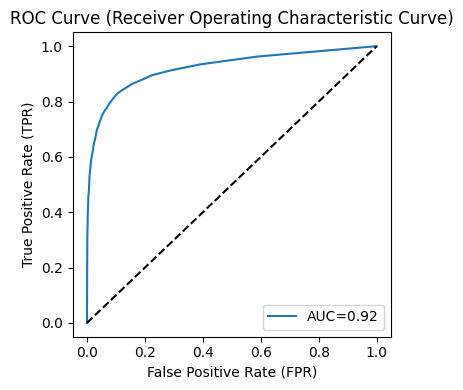

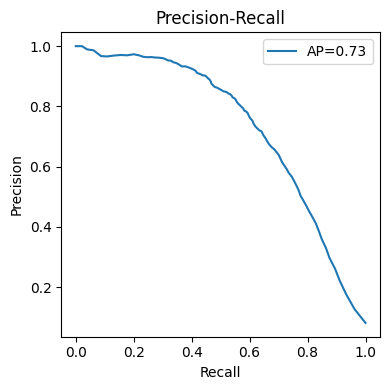

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble      import RandomForestClassifier
from sklearn.metrics       import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

## Preparação dos dados necessários
# Pedidos
orders = datasets['olist_orders_dataset'].copy()
# Converter as colunas de data para datetime
for col in [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_estimated_delivery_date',
    'order_delivered_customer_date'
]:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')
# Filtrar apenas pedidos que foram efetivamente entregues
orders = orders[orders['order_status'] == 'delivered']

# Itens e produtos (para peso / contagem e seller_id)
items = datasets['olist_order_items_dataset'].copy()
# Assegurar tipos corretos
items['order_item_id'] = items['order_item_id'].astype(int)
items['price']         = pd.to_numeric(items['price'], errors='coerce')
items['freight_value'] = pd.to_numeric(items['freight_value'], errors='coerce')

# Para informações de peso e volume
prod = datasets['olist_products_dataset'].copy()
for c in [
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]:
    prod[c] = pd.to_numeric(prod[c], errors='coerce')
# Juntar dimensões ao nível de item
items = items.merge(
    prod[[
        'product_id',
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm'
    ]],
    on='product_id',
    how='left'
)

# Geolocalização (para distância)
geoloc = datasets['olist_geolocation_dataset'].copy()
# Normalizar lat/lon
geoloc['geolocation_lat'] = pd.to_numeric(geoloc['geolocation_lat'], errors='coerce')
geoloc['geolocation_lng'] = pd.to_numeric(geoloc['geolocation_lng'], errors='coerce')
# Média por prefixo
geo = geoloc.groupby('geolocation_zip_code_prefix', as_index=False).agg(
    lat=('geolocation_lat','mean'),
    lng=('geolocation_lng','mean')
)

# Clientes e sellers para prefixo
customers = datasets['olist_customers_dataset'][[
    'customer_id','customer_zip_code_prefix'
]].copy()
sellers = datasets['olist_sellers_dataset'][[
    'seller_id','seller_zip_code_prefix'
]].copy()
# Padronizar 5 dígitos
customers['customer_zip_code_prefix'] = customers['customer_zip_code_prefix'].astype(str).str.zfill(5)
sellers  ['seller_zip_code_prefix'] = sellers ['seller_zip_code_prefix'].astype(str).str.zfill(5)
geo['geolocation_zip_code_prefix'] = geo['geolocation_zip_code_prefix'].astype(str).str.zfill(5)

# Juntar coordenadas a clientes e sellers
customers = customers.merge(
    geo,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={'lat':'cust_lat','lng':'cust_lng'})
sellers = sellers.merge(
    geo,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={'lat':'sell_lat','lng':'sell_lng'})

## Calcular a distância média por pedido
# Associar customer e seller a cada item
itm = items.merge(
    orders[['order_id','customer_id']],
    on='order_id', how='inner'
).merge(
    customers[['customer_id','cust_lat','cust_lng']],
    on='customer_id', how='left'
).merge(
    sellers[['seller_id','sell_lat','sell_lng']],
    on='seller_id', how='left'
)

# Função haversine
def haversine(row):
    lat1, lon1, lat2, lon2 = row['sell_lat'], row['sell_lng'], row['cust_lat'], row['cust_lng']
    if pd.isna(lat1) or pd.isna(lat2):
        return np.nan
    p1, p2 = radians(lat1), radians(lat2)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(p1)*cos(p2)*sin(dlon/2)**2
    return 2 * 6371 * asin(sqrt(a))

# Calcular distância por item
itm['distance_km'] = itm.apply(haversine, axis=1)

# Agrupar para obter média e desvio por pedido
dist_stats = itm.groupby('order_id').agg(
    avg_distance_km=('distance_km','mean'),
    std_distance_km=('distance_km','std')
).reset_index()

## Agregar as features de itens por pedido
# Peso médio e número de itens
item_stats = items.groupby('order_id').agg(
    avg_weight=('product_weight_g','mean'),
    item_count=('order_item_id','count')
).reset_index()

## Montar o dataframe final para o modelo
df = orders.merge(
    dist_stats, on='order_id', how='left'
).merge(
    item_stats, on='order_id', how='left'
)

# Tempo de processamento (h)
df['tempo_processamento_hr'] = (
    df['order_approved_at'] - df['order_purchase_timestamp']
).dt.total_seconds() / 3600

# Tempo de transporte (h)
df['tempo_transporte_hr'] = (
    df['order_delivered_customer_date'] - df['order_delivered_carrier_date']
).dt.total_seconds() / 3600

df['month']   = df['order_purchase_timestamp'].dt.month
df['weekday'] = df['order_purchase_timestamp'].dt.weekday

# Hora, dia e mês da compra
df['hour']  = df['order_purchase_timestamp'].dt.hour
df['weekday'] = df['order_purchase_timestamp'].dt.weekday
df['month'] = df['order_purchase_timestamp'].dt.month

# Target
df['atrasado'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)

## Treino e avaliação
features = [
    'tempo_processamento_hr','tempo_transporte_hr',
    'avg_distance_km','std_distance_km',
    'avg_weight','item_count',
    'hour','weekday','month'
]
X = df[features].fillna(-1)
y = df['atrasado']

# split
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.3,stratify=y,random_state=42
)

# model
model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced',
    random_state=42, n_jobs=-1
)
model.fit(X_train,y_train)

# preds
y_proba   = model.predict_proba(X_test)[:,1]
threshold = 0.5
y_pred    = (y_proba >= threshold).astype(int)

# report
print("Classification Report:")
print(classification_report(y_test,y_pred))
print("Area Under the Receiver Operating Characteristic Curve (ROC AUC):",roc_auc_score(y_test,y_proba))
print("\n")

# ROC curve
fpr,tpr,_ = roc_curve(y_test,y_proba)
plt.figure(figsize=(4,4))
plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_test,y_proba):.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)"); plt.title("ROC Curve (Receiver Operating Characteristic Curve)")
plt.legend()
plt.tight_layout()
plt.show()
print("\n")

# Precision-Recall
prec,rec,_ = precision_recall_curve(y_test,y_proba)
plt.figure(figsize=(4,4))
plt.plot(rec,prec,label=f"AP={auc(rec,prec):.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.legend()
plt.tight_layout()
plt.show()
print("\n")


**Resposta**:
O modelo atinge um AUC de 0.92, o que significa uma boa capacidade de distinguir entregas atrasadas das entregas no prazo. Usando o threshold = 0,5, observa-se poucos falsos positivos (avisos de atraso indevidos), mas apenas 54% dos atrasos reais são capturados, ou seja, quase metade dos atrasos passam despercebidos à previsão.
Em cenários em que não podemos deixar passar atrasos despercebidos, convém reduzir o limiar (por exemplo, para 0.3), o que aumentará o recall da classe “atrasado” mesmo que gere mais falsos positivos.

**Segmentação de Clientes**: Utilize técnicas de clustering para segmentar os clientes em grupos. Analise o comportamento de cada grupo e sugira estratégias de marketing específicas para cada um.

Melhor nº de clusters (Silhouette): 4

Perfil dos segmentos RFM:
         num_clients  recency_mean  freq_mean  mon_mean
cluster                                                
2               2457    289.122914   1.015466  0.087021
3               2962    268.306212   2.116475  0.021246
0              52263    177.926315   1.000000  0.009880
1              38414    438.542927   1.000000  0.009854




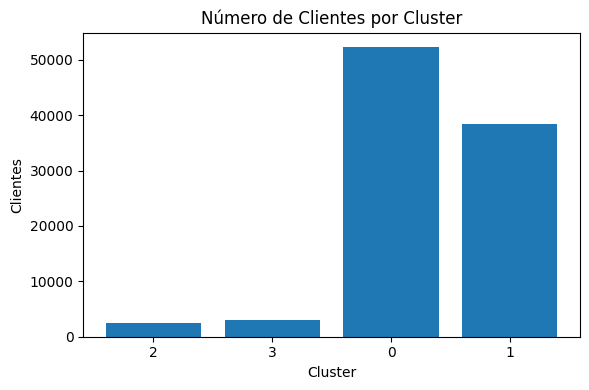



Cluster 2: Ocasional — 2457 clientes
Cluster 3: Frequentes — 2962 clientes
Cluster 0: Ocasional — 52263 clientes
Cluster 1: Churn (antigos) — 38414 clientes




In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster       import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot    as plt
from sklearn.metrics import silhouette_score

# Segmentação de clientes
# Extrair Dataframes
orders   = datasets['olist_orders_dataset'][[
    'order_id','customer_id','order_purchase_timestamp'
]].copy()
payments = datasets['olist_order_payments_dataset'][[
    'order_id','payment_value'
]].copy()
customers= datasets['olist_customers_dataset'][[
    'customer_id','customer_unique_id','customer_state'
]].copy()

## Calcular métricas RFM - calcula recência (dias desde a última compra), frequência (nº de encomendas) e montary (total gasto)
# Monetary: total gasto por pedido
order_vals = (
    payments
    .groupby('order_id', as_index=False)
    .agg(monetary=('payment_value','sum'))
)

# Unir encomendas ao valor e ao cliente
rfm = (
    orders
    .merge(order_vals, on='order_id', how='left')
    .merge(customers, on='customer_id', how='left')
)

# Recency: dias desde última compra
#      Frequency: nº de compras
#      Monetary: soma de gastos
hoje = pd.to_datetime(rfm['order_purchase_timestamp']).max()
rfm = (
    rfm
    .assign(purchase_date=lambda df: pd.to_datetime(df['order_purchase_timestamp']))
    .groupby('customer_unique_id', as_index=False)
    .agg(
        recency_days=('purchase_date', lambda x: (hoje - x.max()).days),
        frequency   =('order_id', 'nunique'),
        monetary    =('monetary', 'sum'),
        state       =('customer_state','first')  # para perfil regional
    )
)

## Escalonar as varáveis RFM
scaler   = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[[
    'recency_days','frequency','monetary'
]])

## Determinar número ótimo de clusters
scores = {}
for k in range(2,7):
    km     = KMeans(n_clusters=k, random_state=42).fit(rfm_scaled)
    scores[k] = silhouette_score(rfm_scaled, km.labels_)

best_k = max(scores, key=scores.get)
print(f"Melhor nº de clusters (Silhouette): {best_k}")

## Treinar K-means e atribuir clusters
kmeans       = KMeans(n_clusters=best_k, random_state=42)
rfm['cluster']= kmeans.fit_predict(rfm_scaled)

## Perfil dos clusters
profile = (
    rfm
    .groupby('cluster')
    .agg(
        num_clients=('customer_unique_id','count'),
        recency_mean=('recency_days','mean'),
        freq_mean=('frequency','mean'),
        mon_mean=('monetary','mean')
    )
    .sort_values('mon_mean', ascending=False)
)
print("\nPerfil dos segmentos RFM:")
print(profile)
print("\n")

## Visualizar a distribuição dos clusters
plt.figure(figsize=(6,4))
plt.bar(profile.index.astype(str), profile['num_clients'])
plt.title("Número de Clientes por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Clientes")
plt.tight_layout()
plt.show()
print("\n")

## Estratégia por segmento
for cid, row in profile.iterrows():
    if row['freq_mean'] > profile['freq_mean'].mean() and row['mon_mean'] > profile['mon_mean'].mean():
        seg_type = "VIP / Alto Valor"
    elif row['freq_mean'] > profile['freq_mean'].mean():
        seg_type = "Frequentes"
    elif row['recency_mean'] > profile['recency_mean'].mean():
        seg_type = "Churn (antigos)"
    else:
        seg_type = "Ocasional"
    print(f"Cluster {cid}: {seg_type} — {int(row['num_clients'])} clientes")
print("\n")




**Conclusão**:
POde-se verificar um pequeno grupo de compradores realmente fiéis no Cluster 3, um nicho menor de "ocasional de alto valor" no cluster 2 e dois blcoos maiores de clintes que compraram só uma vez. As táticas devem variar do reforço de lealdade e elevação de tickets para os frequentes, à reativação e oderta de incentivos para os clientes ocasionais.

**Análise de Satisfação:**
Explore a relação entre a nota de avaliação dos clientes e diferentes aspectos como categoria do produto, tempo de entrega, valor do pedido, etc. Identifique fatores que mais impactam na satisfação do cliente.

Top 10 categorias por review médio:
                                     mean_score  count
main_category                                        
cds_dvds_musicais                     0.916667     12
la_cuisine                            0.886364     11
flores                                0.884615     26
livros_interesse_geral                0.867095    506
construcao_ferramentas_ferramentas    0.856383     94
livros_tecnicos                       0.853113    257
alimentos_bebidas                     0.845815    227
malas_acessorios                      0.834966   1021
fashion_esporte                       0.833333     27
fashion_roupa_infanto_juvenil         0.833333      6




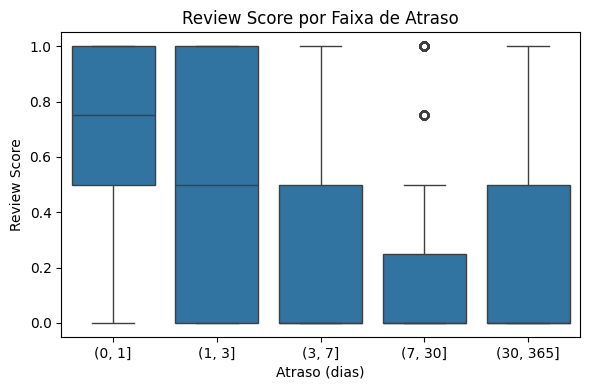

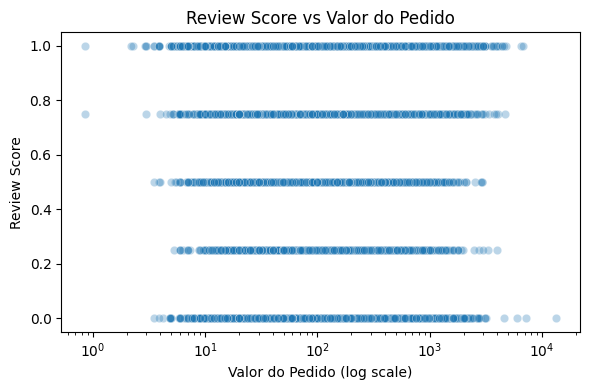




Correlação entre variáveis:
                      delivery_delay_days  order_value  review_score
delivery_delay_days             1.000000     0.016319     -0.263193
order_value                     0.016319     1.000000     -0.039672
review_score                   -0.263193    -0.039672      1.000000



Top 10 features por importância:
 order_value                            0.444970
delivery_delay_days                    0.417769
main_category_esporte_lazer            0.007808
main_category_beleza_saude             0.007622
main_category_utilidades_domesticas    0.006608
main_category_brinquedos               0.005446
main_category_bebes                    0.005208
main_category_cama_mesa_banho          0.005148
main_category_relogios_presentes       0.005125
main_category_automotivo               0.005064
dtype: float64



MSE no conjunto de teste: 0.10




In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble        import RandomForestRegressor
from sklearn.preprocessing  import OneHotEncoder
from sklearn.model_selection import train_test_split

## Extrair dataframes e junção dos dados de review com orders
reviews = datasets['olist_order_reviews_dataset'][
    ['order_id','review_score','review_comment_message']
].copy()
orders = datasets['olist_orders_dataset'][
    ['order_id','order_purchase_timestamp',
     'order_estimated_delivery_date',
     'order_delivered_customer_date']
].copy()

# Converter para datetime
for c in ['order_purchase_timestamp','order_estimated_delivery_date','order_delivered_customer_date']:
    orders[c] = pd.to_datetime(orders[c], errors='coerce')

# Junção reviews ↔ orders
df = reviews.merge(
    orders, on='order_id', how='left'
).dropna(subset=['review_score'])  # garante só reviews válidas

## Tempo de entrega (delay em dias)
df['delivery_delay_days'] = (
    df['order_delivered_customer_date'] - df['order_estimated_delivery_date']
).dt.days.clip(lower=0)  # atrasos negativos são convertidos a 0

## Valor total do pedido
items_val = datasets['olist_order_items_dataset'][[
    'order_id','price'
]].copy()
items_val['price'] = pd.to_numeric(items_val['price'], errors='coerce')

order_value = (
    items_val
    .groupby('order_id', as_index=False)
    .agg(order_value=('price','sum'))
)
df = df.merge(order_value, on='order_id', how='left')

#  Items completo para categoria (precisa de product_id)
items_cat = datasets['olist_order_items_dataset'][[
    'order_id','product_id'
]].copy()

## Categoria principal do pedido
products = datasets['olist_products_dataset'][[
    'product_id','product_category_name'
]].copy()

# Junção product → items → df
itm = items_cat.merge(
    products, on='product_id', how='left'
)

# Para cada pedido, a categoria com maior contagem de itens
top_cat = (
    itm
    .groupby(['order_id','product_category_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['order_id','count'], ascending=[True,False])
    .drop_duplicates('order_id')
    .loc[:, ['order_id','product_category_name']]
)
top_cat.rename(columns={'product_category_name':'main_category'}, inplace=True)

df = df.merge(top_cat, on='order_id', how='left')

## One-hot encoding da categoria
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_ohe = pd.DataFrame(
    enc.fit_transform(df[['main_category']].fillna('unknown')),
    columns=enc.get_feature_names_out(['main_category']),
    index=df.index
)

## Tabela de satisfação média por categoria
cat_sat = (
    df
    .groupby('main_category')['review_score']
    .agg(mean_score='mean', count='size')
    .sort_values('mean_score', ascending=False)
)
print("Top 10 categorias por review médio:\n", cat_sat.head(10))
print("\n")

## Visuzalizações exploratórias
# Boxplot: review vs bins de atraso
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x=pd.cut(df['delivery_delay_days'], bins=[0,1,3,7,30,365]),
    y='review_score'
)
plt.title('Review Score por Faixa de Atraso')
plt.xlabel('Atraso (dias)')
plt.ylabel('Review Score')
plt.tight_layout()
plt.show()
print("\n")

# Scatter: review vs valor do pedido
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df, x='order_value', y='review_score', alpha=0.3
)
plt.xscale('log')
plt.title('Review Score vs Valor do Pedido')
plt.xlabel('Valor do Pedido (log scale)')
plt.ylabel('Review Score')
plt.tight_layout()
plt.show()
print("\n")

# Correlação numérica
corr = df[['delivery_delay_days','order_value','review_score']].corr()
print("\nCorrelação entre variáveis:\n", corr)
print("\n")

## Modelagem - explorar importância de features
# Montar matriz X, y
X = pd.concat([
    df[['delivery_delay_days','order_value']].reset_index(drop=True),
    cat_ohe.reset_index(drop=True)
], axis=1)
y = df['review_score'].reset_index(drop=True)

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Treinar RandomForest
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Importância das features
importances = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)
print("\nTop 10 features por importância:\n", importances.head(10))
print("\n")

# Avaliação do modelo (MSE)
y_pred = model.predict(X_test)
mse    = np.mean((y_pred - y_test)**2)
print(f"\nMSE no conjunto de teste: {mse:.2f}")
print("\n")



**Conclusões**:
Com os resultados obtidos pode-se concluir que o atraso de entrega tem uma correlação negativa moderada com satisfação (-0.26). O valor do pedido também apresenta uma correlação negativa (-0.04) e é a varável mais importante. Para além disso as categorias de produto, apesar de aparecerem no top 10, têm pesos muito pequenos (<1%), indicando que o tipo de produto em si tem impacto residual na nota.
Como conclusão, verifica-se que o fator determinante para a satisfação é o valor do pedido, seguido de atrasos na entrega e a categoria de produto desempenha um papel secundário. Esse insight sugere priorizar otimizações no processo logístico (reduzir atrasos).

# Visualização e Dashboards

**Crie visualizações e dashboards que respondam às seguintes necessidades:**
* Um dashboard geral que mostre a evolução das vendas ao longo do tempo, com filtros por estado e categoria de produto
* Um mapa de calor mostrando a concentração de vendas por região/estado do Brasil
* Um conjunto de gráficos que apresente a relação entre avaliação do cliente e tempo de entrega
* Um dashboard de análise dos vendedores, mostrando quais têm melhor desempenho em termos de volume de vendas, satisfação do cliente e tempo de entrega

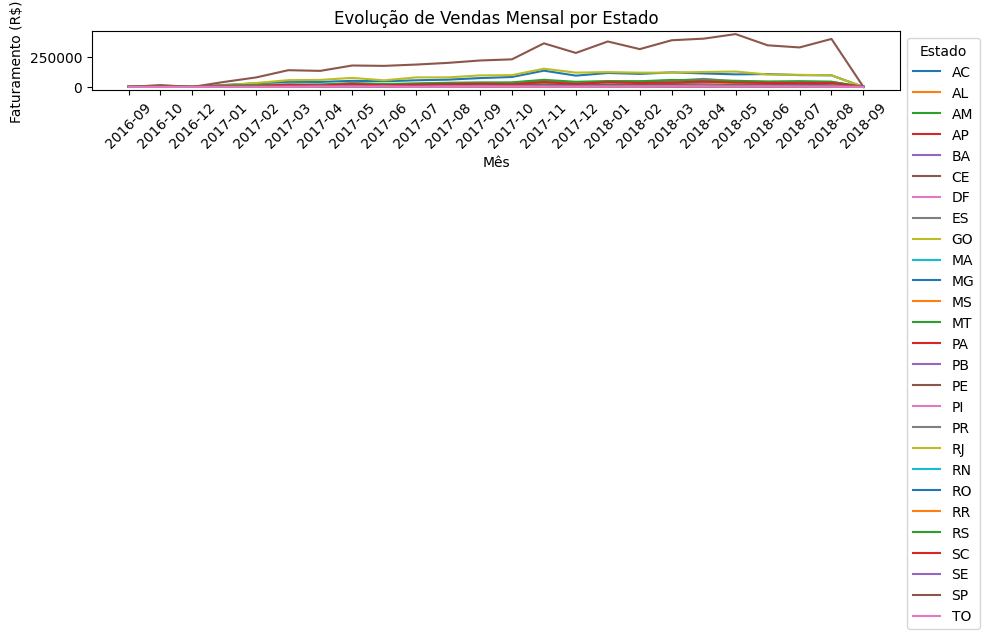

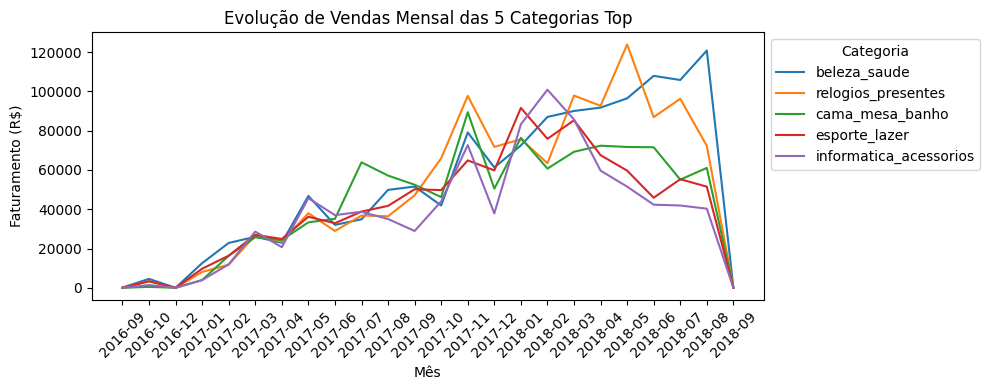

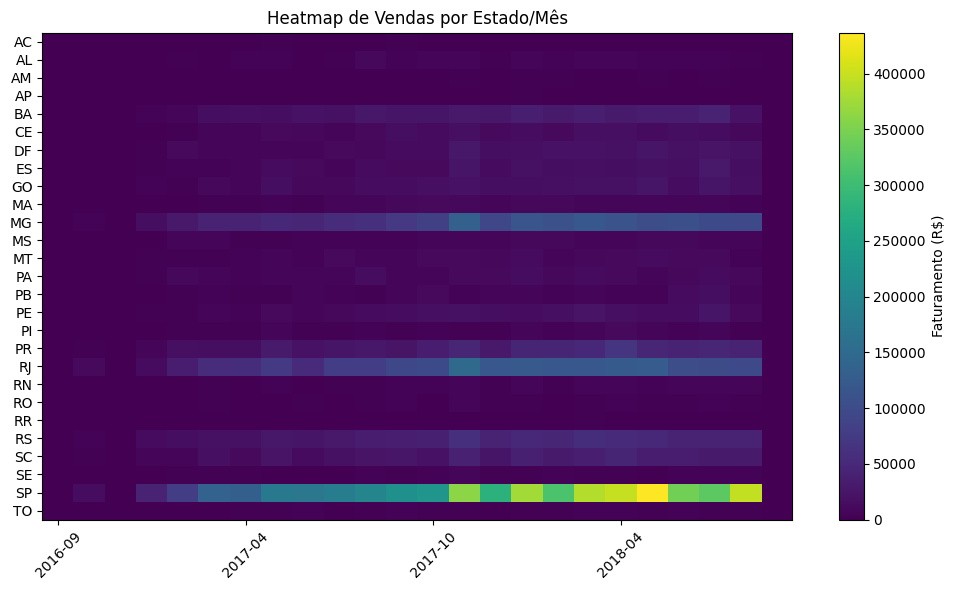

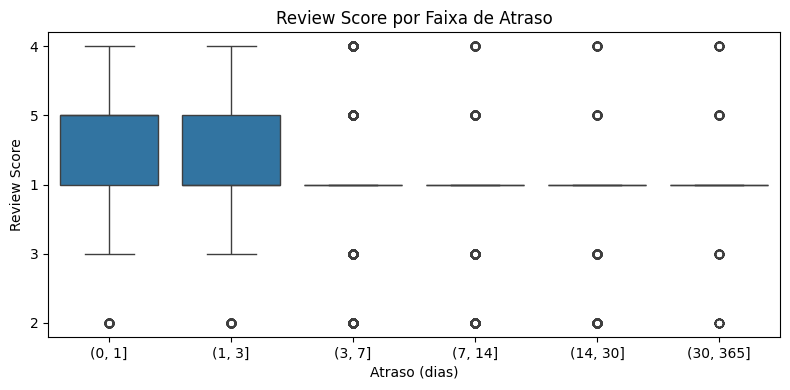

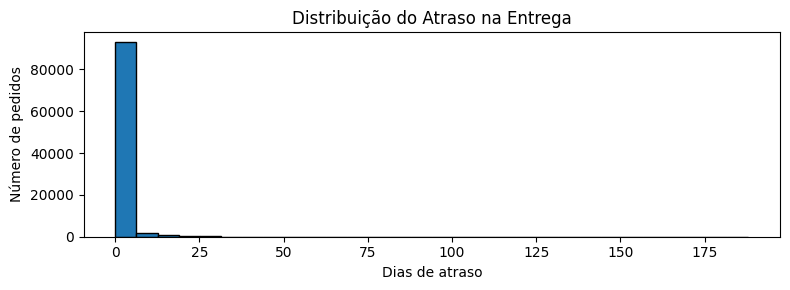



                          seller_id  avg_score
0  0015a82c2db000af6aaaf3ae2ecb0532   3.666667
1  001cca7ae9ae17fb1caed9dfb1094831   3.902542
2  001e6ad469a905060d959994f1b41e4f   1.000000
3  002100f778ceb8431b7a1020ff7ab48f   3.982143
4  003554e2dce176b5555353e4f3555ac8   5.000000




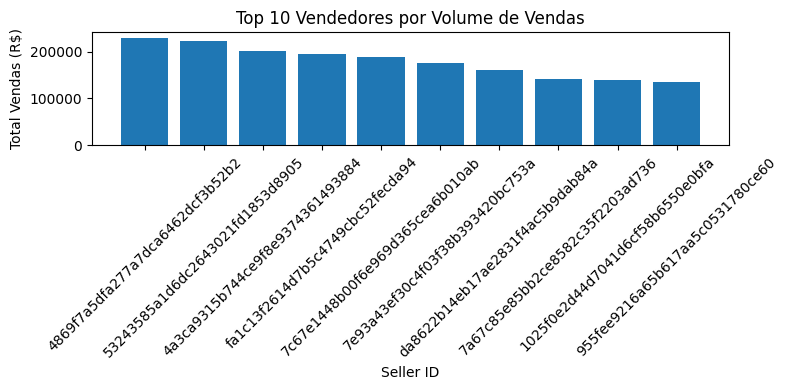

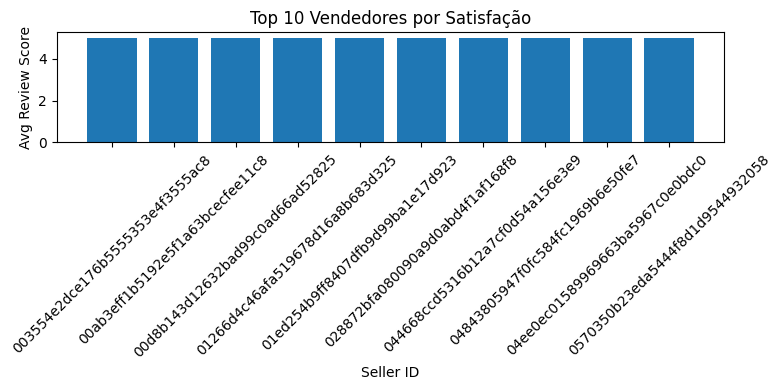

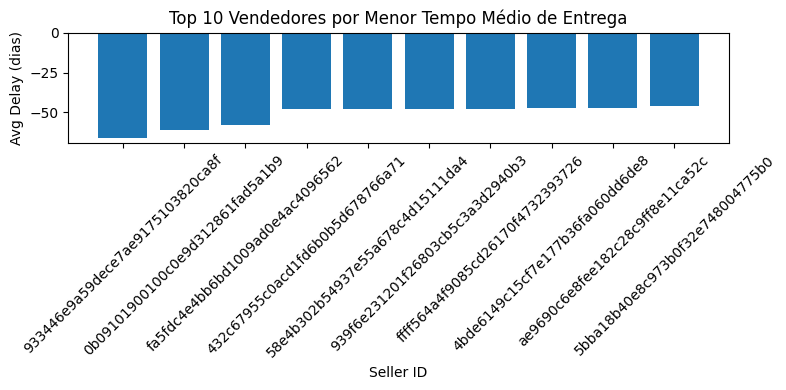

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extrair dataframes
orders = datasets['olist_orders_dataset'].copy()
for col in [
    'order_purchase_timestamp',
    'order_estimated_delivery_date',
    'order_delivered_customer_date'
]:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

items = datasets['olist_order_items_dataset'].copy()
items['price'] = pd.to_numeric(items['price'], errors='coerce')

customers = datasets['olist_customers_dataset'][['customer_id','customer_state']].copy()
products  = datasets['olist_products_dataset'][['product_id','product_category_name']].copy()

## Dashboard da evolução de vendas ao longo do tempo, filtros por estado e categoria
# Juntar orders → items → customers → products
sales = (
    items
    .merge(orders[['order_id','order_purchase_timestamp','customer_id']], on='order_id', how='left')
    .merge(customers, on='customer_id', how='left')
    .merge(products, on='product_id',   how='left')
)

# Extrair coluna ano_mes e converter para string “YYYY-MM”
sales['ano_mes'] = sales['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Pivot por estado
state_revenue = sales[['ano_mes','customer_state','price']].copy()
pivot_state = (
    state_revenue
    .groupby(['ano_mes','customer_state'], as_index=False)
    .agg(faturamento=('price','sum'))
    .pivot(index='ano_mes', columns='customer_state', values='faturamento')
    .fillna(0)
)

# Pivot por categoria
cat_revenue = sales[['ano_mes','product_category_name','price']]
grp_cat     = (
    cat_revenue
    .groupby(['ano_mes','product_category_name'], as_index=False)
    .agg(faturamento=('price','sum'))
)
pivot_cat   = grp_cat.pivot(
    index='ano_mes', columns='product_category_name', values='faturamento'
).fillna(0)

# Gráfico da evolução – Estado
plt.figure(figsize=(10,4))
for st in pivot_state.columns:
    plt.plot(pivot_state.index, pivot_state[st], label=st)
plt.xticks(rotation=45)
plt.title('Evolução de Vendas Mensal por Estado')
plt.xlabel('Mês')
plt.ylabel('Faturamento (R$)')
plt.legend(title='Estado', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()
print("\n")

# Gráfico da evolução – Categoria (exemplo top 5 categorias)
top5 = pivot_cat.sum().sort_values(ascending=False).head(5).index
plt.figure(figsize=(10,4))
for cat in top5:
    plt.plot(pivot_cat.index, pivot_cat[cat], label=cat)
plt.xticks(rotation=45)
plt.title('Evolução de Vendas Mensal das 5 Categorias Top')
plt.xlabel('Mês')
plt.ylabel('Faturamento (R$)')
plt.legend(title='Categoria', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()
print("\n")

# Heatmap de concentração de vendas por região/estado
plt.figure(figsize=(10,6))
plt.imshow(pivot_state.T, aspect='auto', cmap='viridis')
plt.yticks(range(len(pivot_state.columns)), pivot_state.columns)
plt.xticks(range(0,len(pivot_state.index),6), pivot_state.index[::6], rotation=45)
plt.colorbar(label='Faturamento (R$)')
plt.title('Heatmap de Vendas por Estado/Mês')
plt.tight_layout()
plt.show()
print("\n")

## Gráficos de avaliação vs tempo de entrega
# Preparar df_review com delay e score
reviews = datasets['olist_order_reviews_dataset'][['order_id','review_score']].copy()
df_review = reviews.merge(
    orders[['order_id','order_estimated_delivery_date','order_delivered_customer_date']],
    on='order_id', how='left'
)
df_review['delivery_delay'] = (
    (df_review['order_delivered_customer_date'] - df_review['order_estimated_delivery_date'])
    .dt.days.clip(lower=0)
)

# Boxplot por faixas de atraso
plt.figure(figsize=(8,4))
sns.boxplot(
    x=pd.cut(df_review['delivery_delay'], bins=[0,1,3,7,14,30,365]),
    y='review_score',
    data=df_review
)
plt.title('Review Score por Faixa de Atraso')
plt.xlabel('Atraso (dias)')
plt.ylabel('Review Score')
plt.tight_layout()
plt.show()
print("\n")

# Histograma de delays
plt.figure(figsize=(8,3))
plt.hist(df_review['delivery_delay'].dropna(), bins=30, edgecolor='k')
plt.title('Distribuição do Atraso na Entrega')
plt.xlabel('Dias de atraso')
plt.ylabel('Número de pedidos')
plt.tight_layout()
plt.show()
print("\n")

## Dashboard de vendedores: volume, satisfação e tempo de entrega
# Total e número de encomendas por seller
vendor_sales = (
    items
    .groupby('seller_id')
    .agg(total_sales=('price','sum'),
         num_orders =('order_id','nunique'))
    .reset_index()
)

# Satisfação média por seller
vendor_reviews = (
    datasets['olist_order_reviews_dataset'][['order_id','review_score']]
    .copy()
    .assign(review_score=lambda df: pd.to_numeric(df['review_score'], errors='coerce'))
    .dropna(subset=['review_score'])
    .merge(
        items[['order_id','seller_id']],
        on='order_id',
        how='inner'
    )
    .groupby('seller_id', as_index=False)
    .agg(avg_score=('review_score', 'mean'))
)
print(vendor_reviews.head())
print("\n")

# Tempo médio de entrega por seller
vendor_delivery = (
    orders[['order_id','order_estimated_delivery_date','order_delivered_customer_date']]
    .merge(items[['order_id','seller_id']], on='order_id')
    .assign(delay=lambda d:
        (d['order_delivered_customer_date']
         - d['order_estimated_delivery_date']).dt.days
    )
    .groupby('seller_id')
    .agg(avg_delay=('delay','mean'))
    .reset_index()
)

# Unir tudo
df_vperf = (
    vendor_sales
    .merge(vendor_reviews, on='seller_id', how='left')
    .merge(vendor_delivery, on='seller_id', how='left')
)

# Plot top 10 por total_sales
plt.figure(figsize=(8,4))
top = df_vperf.nlargest(10, 'total_sales')
plt.bar(top['seller_id'].astype(str), top['total_sales'])
plt.xticks(rotation=45)
plt.title('Top 10 Vendedores por Volume de Vendas')
plt.xlabel('Seller ID')
plt.ylabel('Total Vendas (R$)')
plt.tight_layout()
plt.show()
print("\n")

# Plot top 10 por avg_score
plt.figure(figsize=(8,4))
top = df_vperf.nlargest(10, 'avg_score')
plt.bar(top['seller_id'].astype(str), top['avg_score'])
plt.xticks(rotation=45)
plt.title('Top 10 Vendedores por Satisfação')
plt.xlabel('Seller ID')
plt.ylabel('Avg Review Score')
plt.tight_layout()
plt.show()
print("\n")

# Plot top 10 por menor avg_delay
plt.figure(figsize=(8,4))
top = df_vperf.nsmallest(10, 'avg_delay')
plt.bar(top['seller_id'].astype(str), top['avg_delay'])
plt.xticks(rotation=45)
plt.title('Top 10 Vendedores por Menor Tempo Médio de Entrega')
plt.xlabel('Seller ID')
plt.ylabel('Avg Delay (dias)')
plt.tight_layout()
plt.show()
print("\n")



Analisando os gráficos anteriores conclui-se que:
*   a maior parte das vendas concentra-se em SP e em algumas categorias
*   atrasos na entrega corroem a satisfação dos clientes
*   existe espaço para melhoria nos vendedores de baixo score médio (especialemnte quem está em 1.0), bem como para ajustar estimativas de entrega
*   focar em capanhas regionais em estados de menor dimensão e reforçar a logística nos vendedores de pior desempenho.

